Attack detection on CPPS using supervised and semi-supervised machine learning models.
Learning strategies like CNN fail to appreciate the spatial features of network and only convolute cells close together in tabular data.
Learning Spatial fetures makes the model more resilient towardsreal world attacks and capable of distinguishing between attack anf fault conditions.

Objective

1.   Model the 118 IEEE bus system as a  graph using Admittance matrix data to make the adjacency matrix.
2. Convert the dataset into Graphs for torch to process.
3. Train a Graph Neural Network on this data to then predict FDIAs.



In [6]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df1=pd.read_csv('gdrive/My Drive/FDIA Detection Using ML Methods/IEE118_normal_results_15k.csv')
df2=pd.read_csv('gdrive/My Drive/FDIA Detection Using ML Methods/IEE118_attack_results_15k.csv')
df = pd.concat([df1,df2])
df = df.sample(frac=1)
df.head()

Mounted at /content/gdrive


,1,2,3,4,5,6,7,8,9,10,...,346,347,348,349,350,351,352,353,354,355
3623,0.973836,1.020509,0.940392,1.013078,1.051549,1.083000,0.943974,0.874568,0.957519,1.034502,...,39.020489,0.028382,67.998241,6.013386,8.082778,21.934307,184.014028,20.006115,32.913118,0
12477,2.240994,1.029830,1.027796,1.063321,0.944718,0.952973,1.039739,1.042421,3.166118,1.095289,...,39.018827,-0.004855,67.911651,5.980804,8.001593,21.937089,184.060468,19.952504,33.004195,1
525,0.981441,1.060838,0.911105,1.091427,1.042745,0.954790,1.011684,0.969845,1.137911,1.035982,...,39.041708,0.058527,68.051553,5.990417,8.056203,22.069591,183.979283,19.983482,32.871268,0
8805,0.839503,0.947029,1.100214,1.026898,1.046146,0.893250,0.905249,1.024646,1.020349,1.032777,...,38.915684,0.007132,67.866919,6.080763,7.919759,22.004493,183.949522,19.942399,33.040305,0
8435,0.911614,0.952117,0.900249,0.982782,1.012281,1.052448,1.048973,1.006483,1.076318,1.005770,...,39.073163,-0.006866,67.983789,5.995961,7.995460,22.019083,184.048437,19.900068,33.005360,1


**Creation Of Adjacency Matrix**


1.   Publicly avaialable Admittance Matrix of an IEEE 188 bus system is taken.
Each entry  a[i][j] into the matrix signifies the admittance value between the connected nodes. All not connected nodes have 0.
2.   We simple convert all non-zero values to 1 and rest remain 0  hence making and adjacency matrix.



In [ ]:
mat = pd.read_csv('gdrive/My Drive/AdmittanceMatrix_118.csv')
mat = mat.to_numpy()
mat = mat[:,1:]
print(mat.shape)
top = []
bottom = []
for i in range(0,118):
  for j in range(0,118):
    if(mat[i][j]==1):
      top.append(i)
      bottom.append(j)
final = np.array([top,bottom])
final = torch.tensor(final,dtype=torch.int)
print(final.shape)


(118, 118)
torch.Size([2, 476])


In [ ]:
datas = df.to_numpy()
datas = datas[:,:]
data_list = []
for element in datas:
  data_xf = element[0:118]
  data_xm = element[118:236]
  data_xs = element[236:354]
  #print(data_xf.shape,data_xs.shape,data_xm.shape)
  tot=[]
  tot.append(data_xf)
  tot.append(data_xs)
  tot.append(data_xm)
  tot = np.array(tot)
  #print(tot,tot.shape)
  data_y = element[-1]
  #print(data_y)
  data_list.append(Data(edge_index=torch.sparse.Tensor(final),x=torch.reshape(torch.tensor(tot,dtype=torch.float),[118,3]),y=torch.tensor(data_y,dtype=torch.long)))

In [ ]:
def split_dataset(dataset, train_ratio=0.9, test_ratio=0.1):
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    test_size = dataset_size - train_size
    return torch.utils.data.random_split(dataset, [train_size,test_size])
data_train, data_test = split_dataset(data_list,0.8,0.2)
print(len(data_train),len(data_test))

24000 6000


In [ ]:
print(data_train[5])

Data(x=[118, 3], edge_index=[2, 476], y=0)


In [ ]:
train_loader = DataLoader(data_train, batch_size=100, shuffle=True)
test_loader = DataLoader(data_test, batch_size=100, shuffle=True)

**Model Creation**

A Graph Neural Network is written with three Convolutional Layers a dropuout layer and Linear layer for output.


In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(3, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


**Compilation And Training**
The model is compiled with cross entropy loss and Adam Optimizer an early stopping startegy is also implemented into the model
The model is then trained over a 1000 epochs stopping early at 236th epoch

In [ ]:
model = GCN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
patience = 50
best_acc = 0
counter = 0
best_model_state = None
def train():
    global best_val_loss
    global counter
    model.train()

    for data in train_loader:
         out = model(data.x, data.edge_index, data.batch)
         loss = criterion(out, data.y)
         loss.backward()
         optimizer.step()
         optimizer.zero_grad()

def test_check(loader):
     model.eval()
     flag =  False
     correct = 0
     for data in loader:
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)
         correct += int((pred == data.y).sum())
     global best_acc
     global counter
     global best_model_state
     #print(best_acc,counter)
     if  correct / len(loader.dataset) > best_acc:
          best_acc = correct / len(loader.dataset)
          counter = 0
          best_model_state = model.state_dict()

     else:
          counter += 1
          if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            flag = True


     return correct / len(loader.dataset),flag

def test(loader):
     model.eval()
     flag =  False
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.



     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
epochs = 1000
for epoch in range(epochs):
    train()
    train_acc = test(train_loader)
    test_acc,flag = test_check(test_loader)

    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    if flag:
      break

Epoch: 000, Train Acc: 0.5606, Test Acc: 0.5675
Epoch: 001, Train Acc: 0.4346, Test Acc: 0.4257
Epoch: 002, Train Acc: 0.7628, Test Acc: 0.7650
Epoch: 003, Train Acc: 0.7404, Test Acc: 0.7407
Epoch: 004, Train Acc: 0.8061, Test Acc: 0.8080
Epoch: 005, Train Acc: 0.8407, Test Acc: 0.8423
Epoch: 006, Train Acc: 0.8627, Test Acc: 0.8647
Epoch: 007, Train Acc: 0.8366, Test Acc: 0.8352
Epoch: 008, Train Acc: 0.8014, Test Acc: 0.8042
Epoch: 009, Train Acc: 0.8947, Test Acc: 0.8967
Epoch: 010, Train Acc: 0.9095, Test Acc: 0.9122
Epoch: 011, Train Acc: 0.8435, Test Acc: 0.8432
Epoch: 012, Train Acc: 0.9220, Test Acc: 0.9262
Epoch: 013, Train Acc: 0.9415, Test Acc: 0.9453
Epoch: 014, Train Acc: 0.9127, Test Acc: 0.9170
Epoch: 015, Train Acc: 0.8934, Test Acc: 0.8930
Epoch: 016, Train Acc: 0.9235, Test Acc: 0.9283
Epoch: 017, Train Acc: 0.9112, Test Acc: 0.9170
Epoch: 018, Train Acc: 0.9007, Test Acc: 0.9043
Epoch: 019, Train Acc: 0.9506, Test Acc: 0.9520
Epoch: 020, Train Acc: 0.9006, Test Acc:

Testing code is reimplemented to return Y_test and Y_pred to help us plot the confusion matrix to provide a consistent metric across the research work.


In [ ]:
def test_predict(loader):
     model.load_state_dict(best_model_state)
     model.eval()
     flag =  False
     correct = 0
     predicted = []
     actual =[]
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         predicted.append(pred)
         actual.append(data.y)
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.



     return actual, predicted  # Derive ratio of correct predictions.

In [ ]:
y_test,y_pred = test_predict(test_loader)
cm = confusion_matrix(y_test,y_pred)

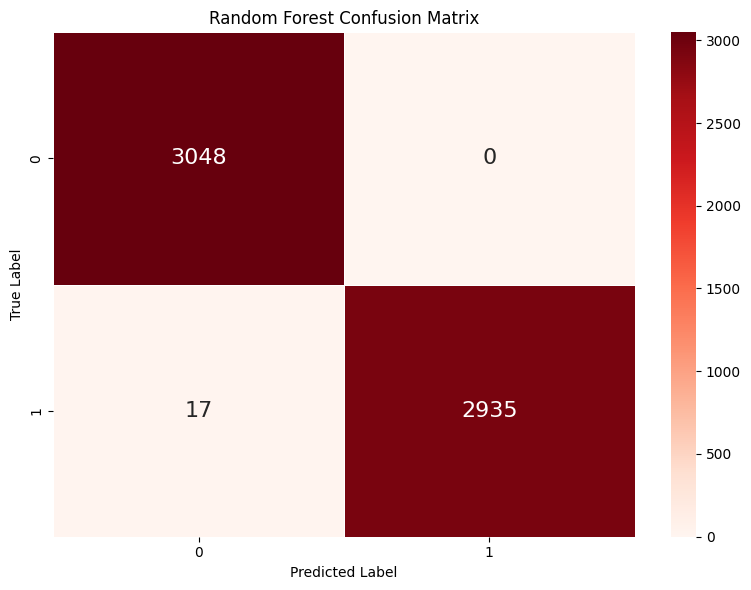

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', linewidths=0.5, annot_kws={"size": 16})
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("cm_rf.png", dpi=600, bbox_inches='tight')
plt.show()